This notebook contains the code and instructions to run Metadynamics Deep Potential Molecular Dynamics simualtions (DPMD) with the trained models of butane using all the datasets and classical (CLC) and Ab initio single point calculation (SPC).

The main idea of this runs is to analyze the dihedral samples of butane during the metadynamics DPMD simulation and compare the Free energy surface results with the reference. The main simulation script is 'ADP_Metadym_DPMD.in'. This file contains importat simulation settings such as the temperature, timestep, siumulation time, and force field to be used. Inside this file you will find a commented par_coeff options that can be uncommented to use any of the trained forcefield for the simulations. The plumed input file (plumed_ADP.dat), now contain parameter to perform metadynamics simulations.

For porposes of this tutorial we will keep working with the butane model Trained with the Uniform distribution (2500 Frames) and the ab initio level of theory, but the same approach will work for any of the other models. Change name of the title of the plot accordingly. 

In [1]:
import plumed
import matplotlib.pyplot as plt
import numpy as np
import math
import subprocess
import warnings
warnings.filterwarnings('ignore')

In [5]:
## Load Colvar data from Metadym DPMD simulation and from the unbias reference

dpmd_colvar = plumed.read_as_pandas('./colvar.dat')
#unbias_colvar = plumed.read_as_pandas('.././Unbias_DPMD/colvar.dat')

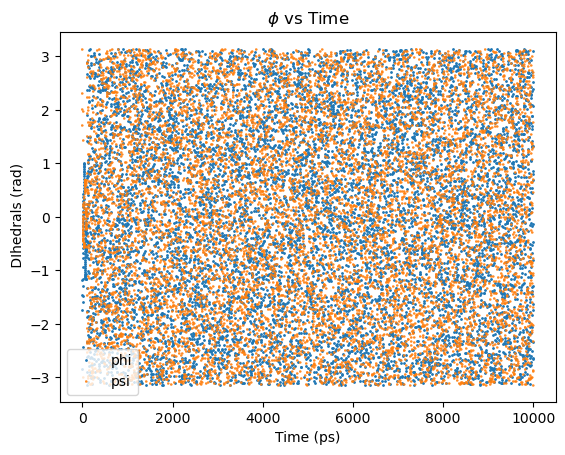

In [9]:
## Plot phi dihedrals

# plot phi during simulation (first 200k points)
start = 0
plt.plot(dpmd_colvar["time"][start:],dpmd_colvar["phi"][start:],'o', ms=1,label="phi")
plt.plot(dpmd_colvar["time"][start:],dpmd_colvar["psi"][start:],'>', ms=1,label="psi")
#plt.plot(unbias_colvar["time"][start:],unbias_colvar["psi"][start:],'>', ms=1,label="Unbias Reference")
#plt.plot(unbiased_data["time"][start:],unbiased_data["phi"][start:],'>', ms=1,label="Unbiased 10ns PHI")
#plt.plot(unbiased_data["time"][start:],unbiased_data["psi"][start:],'>', ms=1,label="Unbiased 10ns PSI")
plt.xlabel("Time (ps)")
plt.ylabel(" DIhedrals (rad)")
plt.legend(frameon=True)
plt.title("$\phi$ vs Time")
plt.show()


In [11]:
## Sum the hills from the metadynamics simualtion. Might need to run in the terminal

stride =1000
converge_every = 40
run_plumed = True ##False
# if run_plumed:
#     subprocess.run(["plumed","sum_hills","--hills","HILLS","--stride",f'{str(stride)}',"--mintozero"])
    

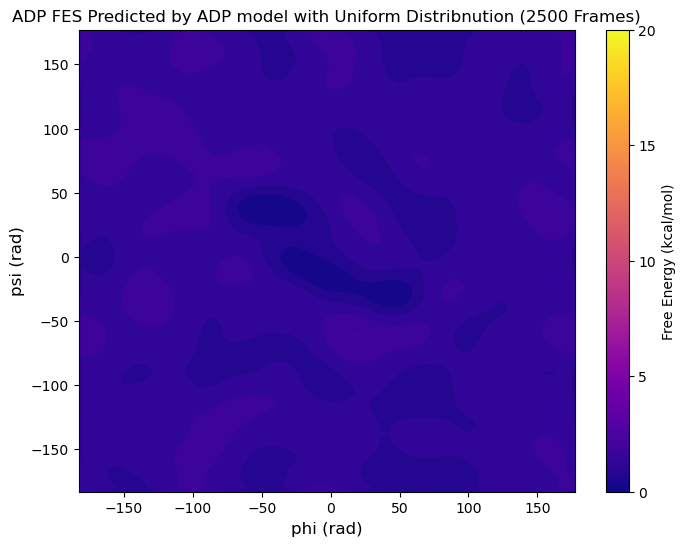

In [15]:
## MAke a 2D plot with the last fes_*.dat file 


import numpy as np
import matplotlib.pyplot as plt

# Load the FES data
fes = np.loadtxt("fes_100.dat")

# Extract the phi, psi, and FES values
phi = np.rad2deg(fes[:, 0])
psi = np.rad2deg(fes[:, 1])
fes_values = fes[:, 2] * 0.239

# Reshape the FES values into a grid
nbins_phi = len(np.unique(phi))
nbins_psi = len(np.unique(psi))
fes_grid = fes_values.reshape(nbins_phi, nbins_psi)

# Create meshgrid for phi and psi
phi_grid, psi_grid = np.meshgrid(np.unique(phi), np.unique(psi))

# Convert the energy to kcal/mol
fes_grid_kcal = fes_grid 

# Set the size and background color of the plot
plt.figure(figsize=(8, 6))
plt.rcParams['axes.facecolor'] = 'white'

# Plot the FES as a surface or grid with modified color scale
plt.pcolormesh(phi_grid, psi_grid, fes_grid_kcal, cmap='plasma', shading='nearest', vmin=0, vmax=20)
plt.colorbar(label="Free Energy (kcal/mol)", ticks=np.arange(0, 21, 5))
plt.xlabel("phi (rad)",fontsize=12)
plt.ylabel("psi (rad)",fontsize=12)
plt.title("ADP FES Predicted by ADP model with Uniform Distribnution (2500 Frames)")

# Add contour lines every 2.5 kcal/mol
contour_levels = np.arange(0, 20, 0.5)
plt.contourf(phi_grid, psi_grid, fes_grid_kcal, levels=contour_levels,cmap='plasma')


plt.show()


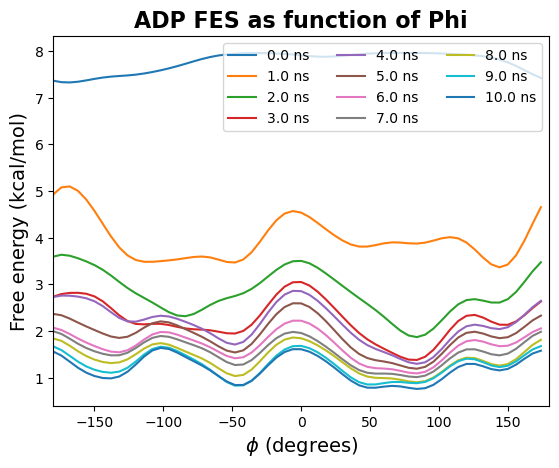

In [20]:
## PLot the predicted FES vs the phi dihedral 



# plot free energy as a function of simulation time
for i in range(0,110,10):   
 # import fes file into pandas dataset
 data=plumed.read_as_pandas("fes_"+str(i)+".dat")
 
 # plot fes
 plt.plot(np.rad2deg(data["phi"][-60:]),data["file.free"][-60:]*0.239, label=str(i/10)+" ns") 
# labels
plt.title("ADP FES as function of Phi",fontsize=16, fontweight="bold")
plt.xlabel("$\phi$ (degrees)", fontsize=14)
plt.ylabel("Free energy (kcal/mol)", fontsize=14)
plt.xlim(-180,180)

plt.legend(ncol=3,fontsize=10,loc='best')
plt.show()


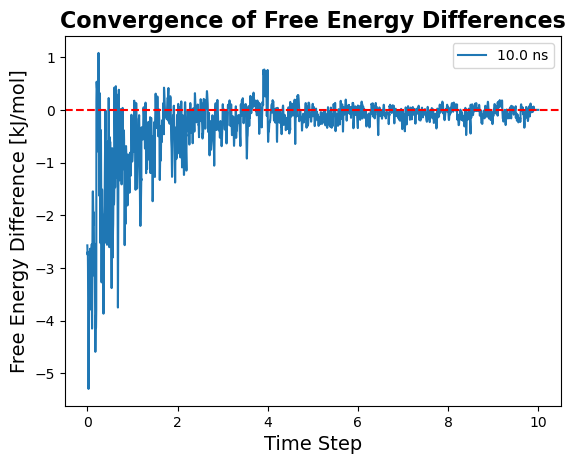

In [21]:
## Check convergence of the predicted FES
import numpy as np
import matplotlib.pyplot as plt
import plumed

def calculate_and_plot_convergence():
    # Array to store the differences
    differences = []

    # Calculate the differences between iterations
    for i in range(0, 101, 1):
        # Import fes file into pandas dataset
        data = plumed.read_as_pandas("fes_" + str(i) + ".dat")

        # Calculate the difference between current and past iteration
        if i > 0:
            diff = data["file.free"].values[-60:] - prev_data["file.free"].values[-60:]
            differences.append(diff)

        # Set previous data for the next iteration
        prev_data = data

    # Plot the differences for convergence
    #for i, diff in enumerate(differences):
    plt.plot(np.arange(len(np.array(differences).flatten()))/600 ,np.array(differences).flatten(), label=str(i/10) + " ns")


    # Plot a horizontal line at 0 for reference
    plt.axhline(y=0, color="red", linestyle="--")
    # Labels
    plt.title("Convergence of Free Energy Differences", fontsize=16, fontweight="bold")
    plt.xlabel("Time Step", fontsize=14)
    plt.ylabel("Free Energy Difference [kJ/mol]", fontsize=14)
    plt.legend(ncol=3)
    
    # 
    plt.show()
    return differences

# Call the function
dif = calculate_and_plot_convergence()
